# Imports & Setup

In [136]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import mne
from tqdm import tqdm
from chbmit.chbmit import FilteredCMP, STFT, CHB_MIT_PAITENT
from mlutils import train

In [137]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [138]:
regression_data = FilteredCMP(512, 1, "/root/physionet.org/files/chbmit/1.0.0/chb01", 3600 * 2, 0, regression=True, use_tok_dim=False)
classification_data = FilteredCMP(512, 1, "/root/physionet.org/files/chbmit/1.0.0/chb01", 3600 * 2, 0, regression=False, use_tok_dim=False)

  0%|          | 0/306 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:32<00:00,  9.95it/s]


# Baseline CNN classifier

## Model & Data Init.

In [104]:
CESP = torch.nn.Sequential(
  STFT(10 * 256, 10 * 256, device=device),
  torch.nn.Conv2d(23, 126, (3, 3)),
  torch.nn.ReLU(),
  torch.nn.MaxPool2d((2, 2)),
  torch.nn.Conv2d(126, 64, (3, 3)),
  torch.nn.ReLU(),
  torch.nn.MaxPool2d((2, 2)),
  torch.nn.Conv2d(64, 64, (3, 3)),
  torch.nn.ReLU(),
  torch.nn.MaxPool2d((2, 2)),
  torch.nn.Flatten(),
  torch.nn.Linear(40448, 4096),
  torch.nn.ReLU(),
  torch.nn.Linear(4096, 256),
  torch.nn.ReLU(),
  torch.nn.Linear(256, 2),
).to(device)

In [105]:
batch_size = 30
learning_rate = 1e-4

training_data, val_data, test_data = torch.utils.data.random_split(classification_data, [0.8, 0.1, 0.1])
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,)

In [106]:
optim = torch.optim.Adam(CESP.parameters(), lr=learning_rate, weight_decay=1e-2)
loss_fn = torch.nn.CrossEntropyLoss(torch.Tensor([1.16, 7.23]).to(device))

## Training & Validation

  0%|          | 0/40 [00:00<?, ?it/s]/opt/conda/envs/ss/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 40/40 [22:35<00:00, 33.89s/it]


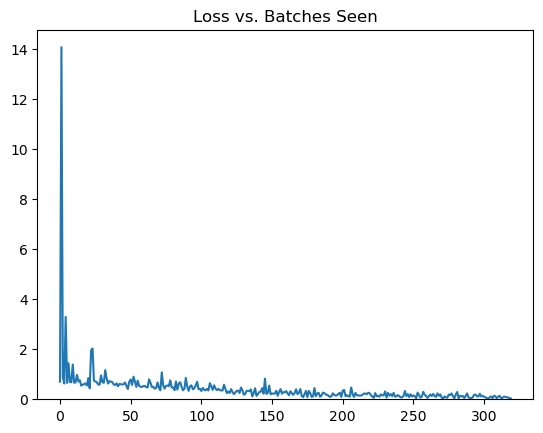

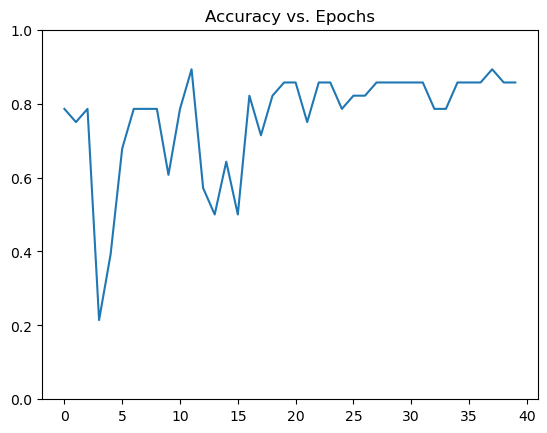

In [107]:
epochs=40
losses = []
accuracy = []
for _ in tqdm(range(epochs)):
  losses.extend(train.train_epoch_classifcation(CESP, train_dataloader, optim, loss_fn=loss_fn, device=device))
  TP, TN, FP, FN = train.validate_binary_softmax(CESP, val_dataloader, device=device)
  accuracy.append((TP + TN) / (TP + FP + TN + FN))

plt.title("Loss vs. Batches Seen")
plt.plot(losses)
plt.ylim(bottom=0)
plt.show()

plt.title("Accuracy vs. Epochs")
plt.plot(accuracy)
plt.ylim((0, 1))
plt.show()

In [108]:
TP, TN, FP, FN = train.validate_binary_softmax(CESP, test_dataloader, device=device)
print(f"Sensitivity: {TP / (TP + FN)}")
print(f"Specificity: {TN / (TN + FP)}")
print(f"Accuracy: {(TP + TN) / (TP + FP + TN + FN)}")
print(f"FPR/h {FP / (FP + TN) / (1 / 6)}")

Sensitivity: 1.0
Specificity: 0.9090909090909091
Accuracy: 0.9259259259259259
FPR/h 0.5454545454545455


# NLL Heteroscedastic (w/ improvements)

**Improvements Made**: 
  - Loss decomposed into classification, regression, and entropy.
  - We weight the classifaction loss using the formula $\frac{N_{total}}{N_{class}}$
  - We minimize the variance directly instead of minimizing entropy

**Notes on Defualt Behavior w/o improvements**:
  - Generally will converge, you'll see two flat regions w/ a phase transition in between when the model learns the classifcation loss. It will improve marginally on the regression loss.
  - Windows tend to be unusably wide
  - Regression Not accurate
  - Classifcation prediction is unconfident and wrong

**Notes on Default Behavior w/ improvements**:
  - In first part of the curve, we see a larger regression loss with classification loss balencing out fairly quickly. Loss is driven to zero fast.
  - Loss isn't really correlated with accuracy after a certain point. Accuracy will continue to improve even after loss stops meaningfully decreasing
  - Large varience in how well training runs do

## Model and Data Init.

In [81]:
REGCNN = torch.nn.Sequential(
  STFT(10 * 256, 10 * 256, device=device),
  torch.nn.Conv2d(23, 126, (3, 3)),
  torch.nn.ReLU(),
  torch.nn.MaxPool2d((2, 2)),
  torch.nn.Conv2d(126, 64, (3, 3)),
  torch.nn.ReLU(),
  torch.nn.MaxPool2d((2, 2)),
  torch.nn.Conv2d(64, 64, (3, 3)),
  torch.nn.ReLU(),
  torch.nn.MaxPool2d((2, 2)),
  torch.nn.Flatten(),
  torch.nn.Linear(40448, 4096),
  torch.nn.ReLU(),
  torch.nn.Linear(4096, 256),
  torch.nn.ReLU(),
  torch.nn.Linear(256, 3),
).to(device)

In [82]:
batch_size = 30
learning_rate = 1e-4
epochs=40

training_data, val_data, test_data = torch.utils.data.random_split(regression_data, [0.8, 0.1, 0.1])
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,)

In [84]:
optim = torch.optim.Adam(REGCNN.parameters(), lr=learning_rate, weight_decay=1e-2)

In [85]:
def SREGLoss(pred, label):
  loss = torch.zeros_like(label)
  prob = torch.nn.functional.sigmoid(pred[..., 0])
  loss[(label == float('inf'))] = -torch.log(1 - prob[(label == float('inf'))] + 1e-8) * 1.16
  loss[(label != float('inf'))] = -torch.log(prob[(label != float('inf'))] + 1e-8) * 7.23
  loss[(label != float('inf'))] += ((label[(label != float('inf'))] - pred[..., 1][(label != float('inf'))]) ** 2) / ((pred[..., 2][(label != float('inf'))] ** 2))
  loss[(label != float('inf'))] += (pred[..., 2][(label != float('inf'))] ** 2)
  return loss.mean(dim=-1)

# Tracks additive components of the loss
def SREGCompLoss(pred, label):
  classifcation_loss = torch.zeros_like(label)
  regression_loss = torch.zeros_like(label)
  prob = torch.nn.functional.sigmoid(pred[..., 0])
  classifcation_loss[(label == float('inf'))] = -torch.log(1 - prob[(label == float('inf'))] + 1e-8) * 1.16
  regression_loss[(label != float('inf'))] = -torch.log(prob[(label != float('inf'))] + 1e-8) * 7.23 
  regression_loss[(label != float('inf'))] += ((label[(label != float('inf'))] - pred[..., 1][(label != float('inf'))]) ** 2) / ((pred[..., 2][(label != float('inf'))] ** 2))
  regression_loss[(label != float('inf'))] += (pred[..., 2][(label != float('inf'))] ** 2)
  return classifcation_loss.mean(dim=-1), regression_loss.mean(dim=-1)

In [86]:
sub_comp = [[], []]
def train_epoch_regression(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, optim: torch.optim.Optimizer, loss_fn = torch.nn.MSELoss(), device=torch.device('cpu'), norm: tuple = (0, 1)) -> list[float]:
  '''
  Args:
    model 
      The model being trained
    dataloader
      The training dataloader
    optim
      The optimizer to use for training
    loss_fn
      (defaults to torch.nn.MSELoss()) the regresison loss to use
    device
      The device on which to train on
    norm : tuple
      A shifting and scaling constant, in that order

  Returns:
    losses: a list of losses for every batch in the epoch
  '''
  losses = []
  for (data, label) in dataloader:
    data = data.to(device).float()
    label = (label.to(device).float() - norm[0]) / norm[1]
    pred = model(data)
    loss = loss_fn(pred, label)
    with torch.no_grad():
      c, r = SREGCompLoss(pred, label)
      sub_comp[0].append(c.item())
      sub_comp[1].append(r.item())

    optim.zero_grad()
    loss.backward()
    optim.step()

    losses.append(loss.item())
  return losses

In [87]:
@torch.inference_mode()
def validate_binary_sigmoid(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, device=torch.device('cpu')):
  """
  Returns summary statistics for a sigmoid based binary classifcation model

  Args:
    model : torch.nn.Module
      the module being evaluated
    dataloader : torch.utils.data.DataLoader
      the data to evalutate on
    device
      the device to run the model on

  Returns:
    statistics : (TP, TN, FP, FN)
      returns the number of True Positives, True Negatives, False Positives, False Negatives accordingly
  """
  TP, TN, FP, FN = 0, 0, 0, 0
  for (data, label) in tqdm(dataloader, leave=False):
    data = data.to(device)
    label = label.to(device)
    prob = model(data)[..., 0]
    pred = torch.zeros_like(prob)
    pred[prob > 0.5] = 1

    TN += ((pred == 0) & (label == float('inf'))).sum(dim=-1).item()
    FN += ((pred == 0) & (label != float('inf'))).sum(dim=-1).item()
    TP += ((pred == 1) & (label != float('inf'))).sum(dim=-1).item()
    FP += ((pred == 1) & (label == float('inf'))).sum(dim=-1).item()
  return TP, TN, FP, FN

## Training & Validation

100%|██████████| 40/40 [21:15<00:00, 31.89s/it]


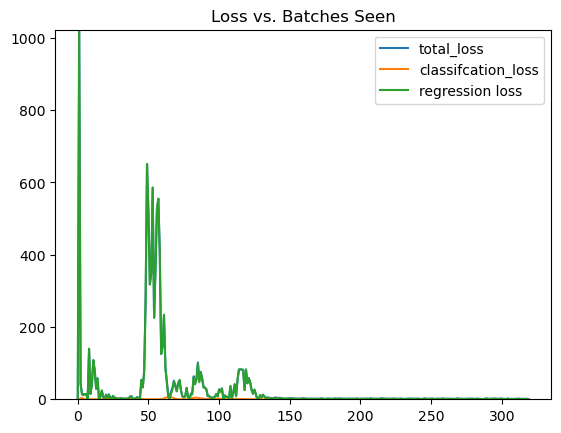

In [88]:
total_losses = []
sub_comp = [[], []]
accuracy = []
for _ in tqdm(range(epochs)):
  total_losses.extend(train_epoch_regression(REGCNN, train_dataloader, optim, loss_fn=SREGLoss, device=device, norm=(2144.7837, 1001.7046)))
  TP, TN, FP, FN = validate_binary_sigmoid(REGCNN, val_dataloader, device=device)
  accuracy.append((TP + TN) / (TP + FP + TN + FN))

  
plt.ylim(bottom=0, top=max(total_losses))
plt.title("Loss vs. Batches Seen")
plt.plot(total_losses, label="total_loss")
plt.plot(sub_comp[0], label="classifcation_loss")
plt.plot(sub_comp[1], label="regression loss")
plt.legend()
plt.show()
plt.title("Accuracy vs. Epochs")
plt.plot(accuracy)
plt.show()

In [90]:
# Seeing how individual examples fair
idx = 12
pred = REGCNN(torch.Tensor(regression_data[idx][0]).unsqueeze(0))
print(pred)
print(torch.sigmoid(pred[0, 0]).item())
print(f"95%: {pred[0, 1] - torch.abs(pred[0, 2])} {pred[0, 1] + torch.abs(pred[0, 2])}")
print(f"95%: {(pred[0, 1] - torch.abs(pred[0, 2]) * 1001.7046 + 2144.7837) / 60} {(pred[0, 1] + torch.abs(pred[0, 2]) * 1001.7046 + 2144.7837) / 60}")
print(f"Center {(pred[0, 1] * 1001.7046 + 2144.7837) / 60}")
print((regression_data[idx][1] - 2144.7837) / 1001.7046, (regression_data[idx][1] / 60))


tensor([[-0.3748, -0.1767, -0.5842]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
0.40736985206604004
95%: -0.7609211206436157 0.40757036209106445
95%: 25.989423751831055 45.49747848510742
Center 32.79678726196289
1.9139537743961643 67.7


In [93]:
#Seeing a summary on test data
TP, TN, FP, FN = validate_binary_sigmoid(REGCNN, train_dataloader, device=device)
print(TP, TN, FP, FN)
print(f"Sensitivity: {TP / (TP + FN)}")
print(f"Specificity: {TN / (TN + FP)}")
print(f"Accuracy: {(TP + TN) / (TP + FP + TN + FN)}")
print(f"FPR/h {FP / (FP + TN) / (1 / 6)}")

1 185 0 33
Sensitivity: 0.029411764705882353
Specificity: 1.0
Accuracy: 0.8493150684931506
FPR/h 0.0


# Multi-Head Hetroscedastic

## Models and Data Init.

In [139]:
class RegressionOnly(CHB_MIT_PAITENT):
  def __init__(self, tok_len: int, ctx_len: int, path: str, sop: int, sph: int,  use_tok_dim: bool=False,):
    super().__init__(tok_len, ctx_len, path, sop, sph, use_tok_dim=use_tok_dim, regression=True)
    self.filtered_idx_list = []
    for i in tqdm(range(super().__len__())):
      data, label = super().__getitem__(i)
      if((np.abs(data) > 1e-8).astype(np.longlong).sum() / data.size > .98 and label != float('inf')):
        self.filtered_idx_list.append(i)

  def __len__(self):
    return len(self.filtered_idx_list)
  
  def __getitem__(self, idx):
    return super().__getitem__(self.filtered_idx_list[idx])

In [140]:
ronly_data = RegressionOnly(512, 1, "/root/physionet.org/files/chbmit/1.0.0/chb01", 3600, 0, use_tok_dim=False)

  0%|          | 0/313 [00:00<?, ?it/s]

100%|██████████| 313/313 [00:31<00:00,  9.81it/s]


In [141]:
class MultHeadCNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.feature_extract = torch.nn.Sequential(
    STFT(10 * 256, 10 * 256, device=device),
      torch.nn.Conv2d(23, 126, (3, 3)),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d((2, 2)),
      torch.nn.Conv2d(126, 64, (3, 3)),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d((2, 2)),
      torch.nn.Conv2d(64, 64, (3, 3)),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d((2, 2)),
      torch.nn.Flatten(),
      torch.nn.Linear(40448, 4096),
      torch.nn.ReLU(),
    )
    self.classifcation_head = torch.nn.Sequential(
      torch.nn.Linear(4096, 256),
      torch.nn.ReLU(),
      torch.nn.Linear(256, 2),
    )
    self.regression_head = torch.nn.Sequential(
      torch.nn.Linear(4096, 256),
      torch.nn.ReLU(),
      torch.nn.Linear(256, 1),
    )
    self.variance_head = torch.nn.Sequential(
      torch.nn.Linear(4096, 256),
      torch.nn.ReLU(),
      torch.nn.Linear(256, 1),
    )
    self.mode_val = 0 # classifcation, regression, window

  def forward(self, data):
    features = self.feature_extract(data)
    if self.mode_val == 0:
      return self.classifcation_head(features)
    elif self.mode_val == 1:
      return self.regression_head(features).flatten()
    else:
      reg = self.regression_head(features.detach()).detach()
      return reg.flatten(), self.variance_head(features.detach()).flatten()

  def mode(self, mode):
    self.mode_val = mode
MHCNN = MultHeadCNN().to(device)

In [142]:
batch_size = 30
learning_rate = 1e-4

training_data, val_data, test_data = torch.utils.data.random_split(classification_data, [0.8, 0.1, 0.1])
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,)

reg_training_data, reg_val_data, reg_test_data = torch.utils.data.random_split(ronly_data, [0.8, 0.1, 0.1])
reg_train_dataloader = torch.utils.data.DataLoader(reg_training_data, batch_size=batch_size, shuffle=True)
reg_val_dataloader = torch.utils.data.DataLoader(reg_val_data, batch_size=batch_size,)
reg_test_dataloader = torch.utils.data.DataLoader(reg_test_data, batch_size=batch_size,)

In [143]:
def HSRLoss(pred, label):
  mean = pred[0]
  var = pred[1]
  loss = torch.zeros_like(label)
  loss += ((label - mean) ** 2) / ((var ** 2))
  loss += torch.sqrt((var ** 2))
  return loss.mean(dim=-1)

In [144]:
def train_epoch_regression(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, optim: torch.optim.Optimizer, loss_fn = torch.nn.MSELoss(), device=torch.device('cpu'), norm: tuple = (0, 1)) -> list[float]:
  '''
  Args:
    model 
      The model being trained
    dataloader
      The training dataloader
    optim
      The optimizer to use for training
    loss_fn
      (defaults to torch.nn.MSELoss()) the regresison loss to use
    device
      The device on which to train on
    norm : tuple
      A shifting and scaling constant, in that order

  Returns:
    losses: a list of losses for every batch in the epoch
  '''
  losses = []
  for (data, label) in dataloader:
    data = data.to(device).float()
    label = (label.to(device).float() - norm[0]) / norm[1]
    pred = model(data)
    loss = loss_fn(pred, label)

    optim.zero_grad()
    loss.backward()
    optim.step()

    losses.append(loss.item())
  return losses

In [145]:
optim = torch.optim.Adam(MHCNN.parameters(), lr=learning_rate, weight_decay=1e-2)
loss_fn = torch.nn.CrossEntropyLoss(torch.Tensor([1.16, 7.23]).to(device))

## Training & Validation

### Training the Classifier

In [146]:
MHCNN.mode(0)

  0%|          | 0/40 [00:00<?, ?it/s]/opt/conda/envs/ss/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 40/40 [22:58<00:00, 34.47s/it]


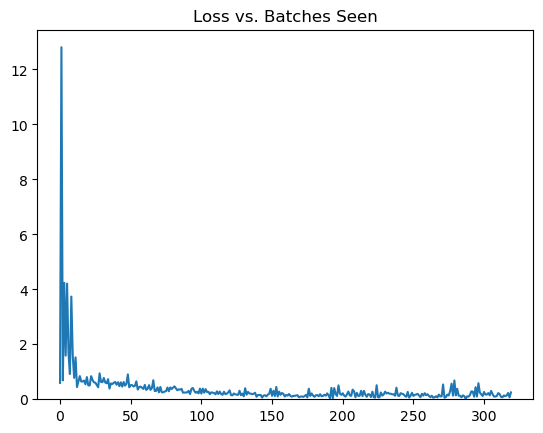

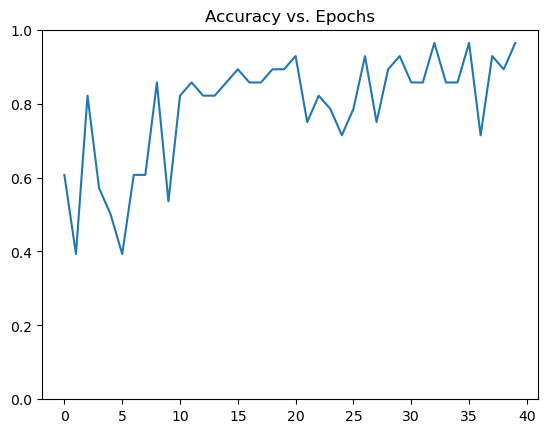

In [147]:
epochs=40
losses = []
accuracy = []
best_accuracy = 0
for _ in tqdm(range(epochs)):
  losses.extend(train.train_epoch_classifcation(MHCNN, train_dataloader, optim, loss_fn=loss_fn, device=device))
  TP, TN, FP, FN = train.validate_binary_softmax(MHCNN, val_dataloader, device=device)
  if((TP + TN) / (TP + FP + TN + FN) > best_accuracy):
    torch.save(MHCNN.state_dict(), "MHCNN.pt")
    best_accuracy = (TP + TN) / (TP + FP + TN + FN)
  accuracy.append((TP + TN) / (TP + FP + TN + FN))

plt.title("Loss vs. Batches Seen")
plt.plot(losses)
plt.ylim(bottom=0)
plt.show()

plt.title("Accuracy vs. Epochs")
plt.plot(accuracy)
plt.ylim((0, 1))
plt.show()

In [148]:
MHCNN.load_state_dict(torch.load("MHCNN.pt"))

<All keys matched successfully>

In [149]:
TP, TN, FP, FN = train.validate_binary_softmax(MHCNN, test_dataloader, device=device)
print(TP, TN, FP, FN)
print(f"Sensitivity: {TP / (TP + FN)}")
print(f"Specificity: {TN / (TN + FP)}")
print(f"Accuracy: {(TP + TN) / (TP + FP + TN + FN)}")
print(f"FPR/h {FP / (FP + TN) / (1 / 6)}")

10 13 4 0
Sensitivity: 1.0
Specificity: 0.7647058823529411
Accuracy: 0.8518518518518519
FPR/h 1.411764705882353


### Training the Windowing Function

In [150]:
norm=(2144.7837, 1001.7046/(1 ** 0.5))

#### Regression

In [151]:
# Training Regression First
MHCNN.mode(1)

In [152]:
epochs=40
losses = []
val_losses = []
best_loss = float('inf')
for _ in tqdm(range(epochs)):
  losses.extend(train.train_epoch_regression(MHCNN, reg_train_dataloader, optim=optim, device=device, norm=norm))
  val_loss = train.validate_epoch_regression(MHCNN, reg_val_dataloader, device=device, norm=norm)
  val_loss = sum(val_loss) / len(val_loss)
  if(val_loss < best_loss):
    torch.save(MHCNN.state_dict(), "MHCNN_R.pt")
    best_loss = val_loss
  val_losses.append(val_loss)

plt.title("Loss vs. Batches Seen")
plt.plot(losses)
plt.ylim(bottom=0)
plt.show()

plt.title("Validate Losses vs. Epochs")
plt.plot(val_losses)
plt.ylim(bottom=0)
plt.show()

 50%|█████     | 20/40 [01:39<01:35,  4.77s/it]

In [ ]:
MHCNN.load_state_dict(torch.load("MHCNN_R.pt"))

<All keys matched successfully>

In [ ]:
test_loss = train.validate_epoch_regression(MHCNN, reg_test_dataloader, device=device, norm=norm)
test_loss = sum(test_loss) / len(test_loss)
print((test_loss * norm[1] + norm[0]) / 60)

66.2708335737606


#### Variance

In [ ]:
# Training Varience
MHCNN.mode(2)

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [03:11<00:00,  4.78s/it]


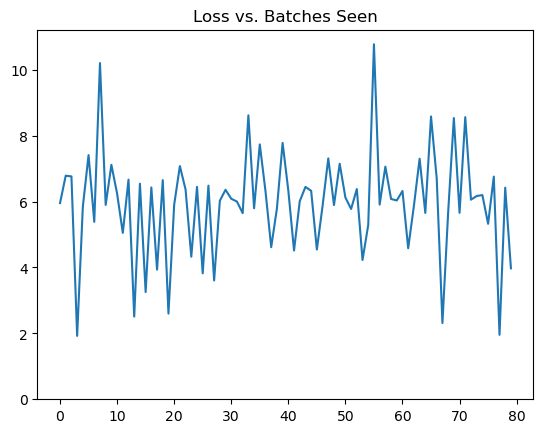

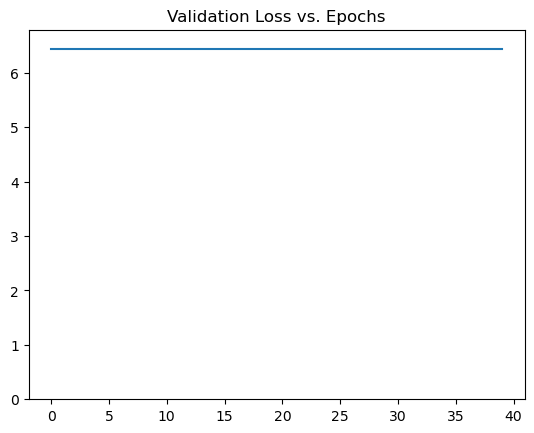

In [ ]:
epochs=40
losses = []
val_losses = []
best_loss = float('inf')
for _ in tqdm(range(epochs)):
  losses.extend(train.train_epoch_regression(MHCNN, reg_train_dataloader, optim=optim, loss_fn=HSRLoss, device=device, norm=norm))
  val_loss = train.validate_epoch_regression(MHCNN, reg_val_dataloader, device=device, loss_fn=HSRLoss, norm=norm)
  val_loss = sum(val_loss) / len(val_loss)
  if(val_loss < best_loss):
    torch.save(MHCNN.state_dict(), "MHCNN_V.pt")
    best_loss = val_loss
  val_losses.append(val_loss)

plt.title("Loss vs. Batches Seen")
plt.plot(losses)
plt.ylim(bottom=0)
plt.show()

plt.title("Validation Loss vs. Epochs")
plt.plot(val_losses)
plt.ylim(bottom=0)
plt.show()

In [ ]:
MHCNN.load_state_dict(torch.load("MHCNN_V.pt"))

<All keys matched successfully>

In [ ]:
best_loss

6.437711238861084

In [ ]:
# Seeing how individual exmples fare
idx = 12
pred = MHCNN(torch.Tensor(ronly_data[idx][0]).unsqueeze(0))
mean = pred[0].detach()
var = pred[1].detach()
print(f"95%: {mean - torch.abs(var)} {mean + torch.abs(var)}")
print(f"95%: {(mean - torch.abs(var) * norm[1] + norm[0]) / 60} {(mean + torch.abs(var) * norm[1] + norm[0]) / 60}")
print(f"Center {(mean * norm[1] + norm[0]) / 60}")
print((ronly_data[idx][1] - norm[0]) / norm[1], (ronly_data[idx][1] / 60))


95%: tensor([-0.7107], device='cuda:0') tensor([1.2461], device='cuda:0')
95%: tensor([27.5837], device='cuda:0') tensor([43.9180], device='cuda:0')
Center tensor([37.9813], device='cuda:0')
1.8872156521992611 51.5
